In [1]:
# load stuff
import json
import random
import numpy as np
from string import digits, ascii_lowercase
import pathlib
import logging

import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
def get_difficulty_threshold(lang: str, difficulty: int):
    return get_difficulty_threshold.thresholds[lang][difficulty]


get_difficulty_threshold.thresholds = {
    'de': {
        0: 10,
        1: 6,
        2: 0
    },
    'en': {
        0: 150,
        1: 100,
        2: 10
    }
}


def get_database(lang: str = "en", difficulty: int = -1) -> dict:
    if lang not in get_database._dbs:
        try:
            file = __file__
        except:
            file = "./.tmp"
        current_folder = pathlib.Path(file).parents[0]
        db_file = str(current_folder / f"{lang}.json")

        logging.info("loading database: %s", lang)

        with open(db_file, "r") as f:
            db = json.load(f)
            get_database._dbs[lang] = {}
            get_database._dbs[lang][-1] = db

        logging.info("database loaded")
    
    if difficulty not in get_database._dbs[lang]:
        t = get_difficulty_threshold(lang, difficulty)
        logging.info("generate sub database for lang %s with difficulty %s", lang, str(difficulty))
        db = get_database._dbs[lang][-1]
        new_db = {}
        for word_key, item in db.items():
            num_translations = item['num_translations']
            if num_translations >= t:
                new_db[word_key] = item
        
        get_database._dbs[lang][difficulty] = new_db

    return get_database._dbs[lang][difficulty]


get_database._dbs = {}

def build_inverted_index(db):

    inverted_db = {}

    inverted_db['#'] = {}
    number_db = inverted_db['#']

    for letter in ascii_lowercase:
        inverted_db[letter] = {}

    for key, item in db.items():
        try:
            word = item['word']
            norm_word = normalize_word(word)

            n = len(norm_word)

            if norm_word.isalnum():

                for i, letter in enumerate(norm_word):
                    letter_db = inverted_db[letter]
                    if i not in letter_db:
                        letter_db[i] = {}
                    letter_db_i = letter_db[i]
                    if n not in letter_db_i:
                        letter_db_i[n] = []
                    if n not in number_db:
                        number_db[n] = []
                    
                    letter_db_i[n].append(key)
                    number_db[n].append(key)
        except:
            pass
            #print("error processing " + word)
    
    return inverted_db

def get_inverted_database(lang: str, difficulty: int = -1) -> dict:
    if lang not in get_inverted_database._dbs:
        get_inverted_database._dbs[lang] = {}
    if difficulty not in get_inverted_database._dbs[lang]:
        get_inverted_database._dbs[lang][difficulty] = build_inverted_index(get_database(lang, difficulty))
    return get_inverted_database._dbs[lang][difficulty]

get_inverted_database._dbs = {}
        

remove_digits = str.maketrans('', '', digits)

def normalize_word(word: str):
    word = word.translate(remove_digits)
    return word.lower()

def find_suitable_words(constraints: list, db: dict, inverted_db: dict):
    sets = []

    n = len(constraints)
    for i,letter in enumerate(constraints):
        if letter == ' ':
            continue
        
        letter_db = inverted_db[letter]
        if i in letter_db:
            i_list = letter_db[i]
            
            if not n in i_list:
                return set()
            
            sets.append(set(i_list[n]))
        
        else:
            return set()
    
    # at least one constraint must be set
    if len(sets) == 0:
        
        # set first letter random and try again
        if n in inverted_db['#']:
            return inverted_db['#'][n]
        return set()
    
    return set.intersection(*sets)
    



In [3]:
%%prun

print(len(find_suitable_words(list("  "), get_database(
    "de", difficulty=0), get_inverted_database("de", difficulty=0))))


40
 

         325711 function calls (325710 primitive calls) in 0.776 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.533    0.533    0.533    0.533 decoder.py:343(raw_decode)
        1    0.118    0.118    0.183    0.183 <ipython-input-2-3db35396d80b>:54(build_inverted_index)
        1    0.029    0.029    0.044    0.044 {method 'read' of '_io.TextIOWrapper' objects}
   250884    0.028    0.000    0.028    0.000 {method 'append' of 'list' objects}
    14931    0.019    0.000    0.019    0.000 {method 'translate' of 'str' objects}
        1    0.015    0.015    0.015    0.015 {built-in method _codecs.utf_8_decode}
        2    0.014    0.007    0.593    0.296 <ipython-input-2-3db35396d80b>:19(get_database)
    14931    0.009    0.000    0.031    0.000 <ipython-input-2-3db35396d80b>:103(normalize_word)
    14931    0.003    0.000    0.003    0.000 {method 'isalnum' of 'str' objects}
    14931    0.003    0.000    0

In [4]:
class NoDataException(Exception):
    pass


class WordInfo(object):
    def __init__(self, word: str, y: int, x: int, is_vertical: bool, database: dict, opposite_prefix: str = "opposite of", synonym_prefix: str = "other word for"):
        self._dictionary_database = database
        self._y = y
        self._x = x
        self._word = word
        self._hint = None
        self._is_vertical = is_vertical

        self.opposite_prefix = opposite_prefix
        self.synonym_prefix = synonym_prefix

        self.choose_info()

    def get_attribute(self, attr: str):
        attr = self._dictionary_database[self._word][attr]
        if attr is None or len(attr) == 0:
            raise NoDataException
        return attr

    def get_best_antonym(self) -> str:
        antonyms = self.get_attribute("antonyms")
        return random.choice(antonyms)

    def get_best_synonym(self) -> str:
        synonyms = self.get_attribute("synonyms")
        return random.choice(synonyms)

    def get_best_sense(self) -> str:
        senses = self.get_attribute("senses")
        return random.choice(senses)

    def choose_info(self, n: int = 1):
        assert n <= 4
        # first choose antonyms, then synonyms, then senses

        hints = []

        try:
            antonyms = self.get_attribute("antonyms")
            antonyms = [f"{self.opposite_prefix} {w}" for w in antonyms]
            hints = hints + antonyms
        except NoDataException:
            pass

        try:
            synonyms = self.get_attribute("synonyms")
            synonyms = [f"{self.synonym_prefix} {w}" for w in synonyms]

            hints = hints + synonyms
        except NoDataException:
            pass

        try:
            senses = self.get_attribute("senses")
            hints = hints + senses
        except NoDataException:
            pass

        final_hints = []
        for i in range(n):
            choice = random.choice(hints)
            hints.remove(choice)
            final_hints.append(choice)

        if n == 1:
            self._hint = final_hints[0]
            return

        hint_symbols = ['a)', 'b)', 'c)', 'd)']

        self._hint = ""
        for i in range(n):
            self._hint += hint_symbols[i] + " " + final_hints[i] + ". "

    def get_hint(self) -> str:
        return self._hint

    def get_hint_location(self):
        x = self._x if self._is_vertical else self._x - 1
        y = self._y - 1 if self._is_vertical else self._y
        return (y, x)

    def is_vertical(self):
        return self._is_vertical


In [5]:
TYPE_EMPTY = -1
TYPE_NEIGHBOR = -2
TYPE_BLOCKED = -3


class GridCreationWord(object):
    def __init__(self, y: int, x: int, length: int, is_vertical: bool, id: int) -> None:
        self.y = y
        self.x = x
        self.length = length
        self.is_vertical = is_vertical
        self.id = id

        self.word_key = None
        self.connected_words = []

    def get_letters(self, letter_grid: np.ndarray) -> list:
        if self.is_vertical:
            return letter_grid[self.y:self.y+self.length, self.x].flatten()
        return letter_grid[self.y, self.x: self.x + self.length].flatten()

    def write(self, word: str, letter_grid: np.ndarray, x_grid: np.ndarray, y_grid: np.ndarray):
        letters = list(word)
        if self.is_vertical:

            xmin = max(self.x - 1, 0)
            xmax = min(self.x + 2, letter_grid.shape[1])
            ymin = self.y
            ymax = self.y + self.length

            letter_grid[ymin:ymax, self.x] = letters

            conflicts = np.argwhere(
                x_grid[ymin:ymax, self.x] == TYPE_NEIGHBOR
            )
            if len(conflicts) > 0:
                corrected_conflicts = np.zeros(
                    shape=(len(conflicts), 2), dtype=np.int)
                corrected_conflicts[:, 0] = ymin + conflicts.flatten()
                corrected_conflicts[:, 1] = self.x
                conflicts = corrected_conflicts

            x_neighbors = x_grid[ymin:ymax, xmin:xmax]
            x_neighbors[x_neighbors == TYPE_EMPTY] = TYPE_NEIGHBOR
            x_grid[ymin:ymax, xmin:xmax] = x_neighbors

            x_grid[ymin:ymax, self.x] = self.id

            fields_to_block = y_grid[ymin:ymax, self.x]
            fields_to_block[fields_to_block < 0] = TYPE_BLOCKED
            y_grid[ymin:ymax, self.x] = fields_to_block

            if ymin > 0:
                x_grid[ymin - 1, self.x] = TYPE_BLOCKED
                y_grid[ymin - 1, self.x] = TYPE_BLOCKED

            if ymax < letter_grid.shape[0]:

                x_grid[ymax, self.x] = TYPE_BLOCKED
                y_grid[ymax, self.x] = TYPE_BLOCKED

        else:

            xmin = self.x
            xmax = self.x + self.length
            ymin = max(self.y - 1, 0)
            ymax = min(self.y + 2, letter_grid.shape[0])

            letter_grid[self.y, xmin:xmax] = letters

            conflicts = np.argwhere(
                y_grid[self.y, xmin:xmax] == TYPE_NEIGHBOR,
            )
            if len(conflicts) > 0:
                corrected_conflicts = np.zeros(
                    shape=(len(conflicts), 2), dtype=np.int)
                corrected_conflicts[:, 1] = xmin + conflicts.flatten()
                corrected_conflicts[:, 0] = self.y
                conflicts = corrected_conflicts

            y_neighbors = y_grid[ymin:ymax, xmin:xmax]
            y_neighbors[y_neighbors == TYPE_EMPTY] = TYPE_NEIGHBOR
            y_grid[ymin:ymax, xmin:xmax] = y_neighbors

            fields_to_block = x_grid[self.y, xmin:xmax]
            fields_to_block[fields_to_block < 0] = TYPE_BLOCKED
            x_grid[self.y, xmin:xmax] = fields_to_block

            y_grid[self.y, xmin:xmax] = self.id

            if xmin > 0:
                x_grid[self.y, xmin - 1] = TYPE_BLOCKED
                y_grid[self.y, xmin - 1] = TYPE_BLOCKED

            if xmax < letter_grid.shape[1]:

                x_grid[self.y, xmax] = TYPE_BLOCKED
                y_grid[self.y, xmax] = TYPE_BLOCKED

        return conflicts

    def set_word_key(self, word_key: str):
        self.word_key = word_key

    def connect_word(self, grid_word):
        self.connected_words.append(grid_word)

    def get_connected_words(self):
        return self.connected_words

    def check_connected(self, grid_word):
        if self.is_vertical == grid_word.is_vertical:
            return False

        if self.is_vertical:
            if self.y > grid_word.y:
                return False
            if self.y + self.length <= grid_word.y:
                return False

            if self.x >= grid_word.x + grid_word.length:
                return False

            if self.x < grid_word.x:
                return False

        else:
            if self.x > grid_word.x:
                return False
            if self.x + self.length <= grid_word.x:
                return False
            if self.y >= grid_word.y + grid_word.length:
                return False
            if self.y < grid_word.y:
                return False

        return True


class GridCreationState(object):
    def __init__(self, h: int, w: int, db, inverted_db, old_state=None) -> None:
        if old_state is not None:
            self.h = h
            self.w = w
            self.db = db
            self.inverted_db = inverted_db
            self.x_grid = old_state.x_grid.copy()
            self.y_grid = old_state.y_grid.copy()
            self.letter_grid = old_state.letter_grid.copy()
            self.placed_words = old_state.placed_words.copy()
            self.used_word_keys = old_state.used_word_keys.copy()

            return

        self.h = h
        self.w = w
        self.x_grid = np.full(shape=(h, w), dtype=np.int,
                              fill_value=TYPE_EMPTY)
        self.y_grid = np.full(shape=(h, w), dtype=np.int,
                              fill_value=TYPE_EMPTY)

        self.letter_grid = np.full(
            shape=(h, w), dtype=np.unicode, fill_value=' ')

        self.placed_words = []
        self.used_word_keys = set()

        self.db = db
        self.inverted_db = inverted_db

    def write_word(self, word_key: str, y: int, x: int, is_vertical: bool):
        id = len(self.placed_words)

        word_raw = self.db[word_key]['word']
        word_normalized = normalize_word(word_raw)

        grid_word = GridCreationWord(y=y,
                                     x=x,
                                     length=len(word_normalized),
                                     is_vertical=is_vertical, id=id)

        grid_word.set_word_key(word_key=word_key)

        conflicts = grid_word.write(word=word_normalized,
                                    letter_grid=self.letter_grid,
                                    x_grid=self.x_grid,
                                    y_grid=self.y_grid)

        self.placed_words.append(grid_word)
        self.used_word_keys.add(word_key)

        return conflicts

    def copy(self):
        return GridCreationState(self.h, self.w, self.db, self.inverted_db, self)

    def get_density(self):

        blocked_fields_x = np.logical_or(
            self.x_grid >= 0, self.x_grid == TYPE_BLOCKED)
        blocked_fields_y = np.logical_or(
            self.y_grid >= 0, self.y_grid == TYPE_BLOCKED)

        blocked_fields = np.logical_or(blocked_fields_x, blocked_fields_y)

        return np.sum(blocked_fields) / (self.w * self.h)

    def get_letters(self, y: int, x: int, length: int, is_vertical: bool):
        if is_vertical:
            return self.letter_grid[y:y+length, x].flatten()
        return self.letter_grid[y, x:x+length].flatten()

    def get_max_extents(self, y: int, x: int, is_vertical: bool):
        # check min max offsets
        if is_vertical:
            min_coord = y - 1
            if min_coord < 0 or self.y_grid[min_coord, x] == TYPE_BLOCKED:
                min_coord = y
            else:
                while min_coord > 0 and self.y_grid[min_coord - 1, x] != TYPE_BLOCKED:
                    min_coord -= 1
            max_coord = y + 1
            while max_coord < self.h and self.y_grid[max_coord, x] != TYPE_BLOCKED:
                max_coord += 1

            return min_coord, max_coord
        else:
            min_coord = x - 1
            if min_coord < 0 or self.x_grid[y, min_coord] == TYPE_BLOCKED:
                min_coord = x
            else:
                while min_coord > 0 and self.x_grid[y, min_coord - 1] != TYPE_BLOCKED:
                    min_coord -= 1
            max_coord = x + 1
            while max_coord < self.w and self.x_grid[y, max_coord] != TYPE_BLOCKED:
                max_coord += 1
            return min_coord, max_coord

    def expand_coordinates(self, y: int, x: int, length: int, is_vertical: bool):
        if is_vertical:
            min_coord = y
            max_coord = y + length
            while min_coord > 0 and self.y_grid[min_coord - 1, x] >= 0:
                min_coord -= 1
            while max_coord < self.h and self.y_grid[max_coord, x] >= 0:
                max_coord += 1

            return min_coord, max_coord
        else:
            min_coord = x
            max_coord = x + length
            while min_coord > 0 and self.x_grid[y, min_coord - 1] >= 0:
                min_coord -= 1
            while max_coord < self.w and self.x_grid[y, max_coord] >= 0:
                max_coord += 1

            return min_coord, max_coord

    def place_random_word(self, min_length: int = 4, max_length: int = 15):
        # first, find a random intersection
        letter_locations = np.argwhere(self.letter_grid != ' ')
        if len(letter_locations) == 0:
            # if nothing is placed so far, just choose a random place
            length = np.random.randint(min_length, max_length)
            length = min(length, max_length)
            y = np.random.randint(0, self.h - 1)
            x = np.random.randint(0, self.w - length)
            is_vertical = False
            word_template = " " * length
        else:
            # possible candidates are fields where words are placed
            # only horizontally or only vertically
            candidates = np.argwhere(
                np.logical_xor(self.x_grid >= 0, self.y_grid >= 0)
            )

            if len(candidates) == 0:
                #print("field is full")
                return None

            candidate_index = random.randint(0, len(candidates) - 1)
            y, x = candidates[candidate_index]

            is_vertical = self.x_grid[y, x] == TYPE_BLOCKED

            min_coord, max_coord = self.get_max_extents(y, x, is_vertical)

            extent = max_coord - min_coord

            if extent < min_length:
                #print("not enough space to place a word")
                return None

            min_length = min(extent, min_length)
            max_length = min(extent, max_length)

            length = random.randint(min_length, max_length)
            offset = random.randint(0, extent - length)

            min_coord += offset

            if is_vertical:
                if min_coord + length <= y:
                    min_coord = y - length + 1
                    max_coord = min_coord + length
                if min_coord > y:
                    min_coord = y
                    max_coord = min_coord + length

                min_coord, max_coord = self.expand_coordinates(y=min_coord,
                                                               x=x,
                                                               length=length,
                                                               is_vertical=is_vertical)

                length = max_coord - min_coord

                letters = self.get_letters(min_coord, x, length, is_vertical)

                y = min_coord

            else:

                if min_coord + length <= x:
                    min_coord = x - length + 1
                    max_coord = min_coord + length
                if min_coord > x:
                    min_coord = x
                    max_coord = min_coord + length

                min_coord, max_coord = self.expand_coordinates(y=y,
                                                               x=min_coord,
                                                               length=length,
                                                               is_vertical=is_vertical)

                length = max_coord - min_coord

                letters = self.get_letters(y, min_coord, length, is_vertical)

                x = min_coord

            word_template = "".join(letters)

        word_candidates = list(find_suitable_words(
            word_template, self.db, self.inverted_db))

        if len(word_candidates) == 0:
            #print("no word available for given combination")
            return None

        word_candidate_index = random.randint(0, len(word_candidates) - 1)
        word_key = word_candidates[word_candidate_index]

        if word_key in self.used_word_keys:
            return None

        return self.write_word(word_key, y, x, is_vertical)

    def solve_conflicts(self, conflicts, n_retries=3, max_depth=5, depth=0):
        if len(conflicts) == 0:
            return self
        # else:
        #    return None

        if depth > max_depth:
            return None

        new_conflictes = []

        for conflict in conflicts:

            y, x = conflict

            if self.x_grid[y, x] >= 0 and self.y_grid[y, x] >= 0:
                # conflict already solved
                continue

            # find out whether the conflict is vertical or horizontal
            is_vertical = self.y_grid[y, x] == TYPE_NEIGHBOR

            # calculate the minimum and maximum extend to fix the conflict
            if is_vertical:
                max_ymin = y
                while max_ymin > 0 and self.y_grid[max_ymin-1, x] >= 0:
                    max_ymin -= 1
                min_ymax = y + 1
                while min_ymax < self.h and self.y_grid[min_ymax, x] >= 0:
                    min_ymax += 1

                min_ymin = max_ymin
                while min_ymin > 0 and self.y_grid[min_ymin - 1, x] != TYPE_BLOCKED:
                    min_ymin -= 1
                max_ymax = min_ymax
                while max_ymax < self.h and self.y_grid[max_ymax, x] != TYPE_BLOCKED:
                    max_ymax += 1

                min_coord_min = min_ymin
                max_coord_min = max_ymin
                min_coord_max = min_ymax
                max_coord_max = max_ymax

            else:
                max_xmin = x
                while max_xmin > 0 and self.x_grid[y, max_xmin - 1] >= 0:
                    max_xmin -= 1
                min_xmax = x + 1
                while min_xmax < self.w and self.x_grid[y, min_xmax] >= 0:
                    min_xmax += 1

                min_xmin = max_xmin
                while min_xmin > 0 and self.x_grid[y, min_xmin - 1] != TYPE_BLOCKED:
                    min_xmin -= 1
                max_xmax = min_xmax
                while max_xmax < self.w and self.x_grid[y, max_xmax] != TYPE_BLOCKED:
                    max_xmax += 1

                min_coord_min = min_xmin
                max_coord_min = max_xmin
                min_coord_max = min_xmax
                max_coord_max = max_xmax

            n_options = max_coord_max - min_coord_max + max_coord_min - min_coord_min

            solved = False

            for _ in range(min(n_options, n_retries)):
                coord_min = random.randint(min_coord_min, max_coord_min)
                coord_max = random.randint(min_coord_max, max_coord_max)
                length = coord_max - coord_min
                if length < 2:
                    continue

                if is_vertical:

                    coord_min, coord_max = self.expand_coordinates(y=coord_min,
                                                                   x=x,
                                                                   length=length,
                                                                   is_vertical=is_vertical)

                    length = coord_max - coord_min

                    y = coord_min

                else:

                    coord_min, coord_max = self.expand_coordinates(y=y,
                                                                   x=coord_min,
                                                                   length=length,
                                                                   is_vertical=is_vertical)

                    length = coord_max - coord_min

                    x = coord_min

                letters = self.get_letters(y, x, length, is_vertical)

                word_template = "".join(letters)

                candidates = list(find_suitable_words(
                    word_template, self.db, self.inverted_db))

                if len(candidates) == 0:
                    continue

                candidate_index = random.randint(0, len(candidates) - 1)
                word_key = candidates[candidate_index]

                if word_key in self.used_word_keys:
                    continue

                word_conflicts = self.write_word(word_key, y, x, is_vertical)
                if len(word_conflicts) > 0:
                    new_conflictes.append(word_conflicts)

                solved = True
                break

            if not solved:
                return None

        if len(new_conflictes) == 0:
            return self

        new_conflictes = np.concatenate(new_conflictes)
        for _ in range(n_retries):
            next_state = self.copy()
            solved_state = next_state.solve_conflicts(
                new_conflictes, n_retries, max_depth, depth + 1)
            if solved_state is not None:
                return solved_state
        return None

    def fill_grid(self, target_density: float = 0.6, inner_retries: int = 5, conflict_retries: int = 10, conflict_solver_depth=5, min_length: int = 4, max_length: int = 10, max_iterations: int = 1000):
        i = 0
        state = self.copy()
        while i < max_iterations and state.get_density() < target_density:
            i += 1
            new_state = state.copy()
            conflicts = new_state.place_random_word(min_length, max_length)
            if conflicts is None:
                continue
            if len(conflicts) == 0:
                state = new_state

            if len(conflicts) > 0:
                
                solved_state = new_state.solve_conflicts(
                    conflicts, inner_retries, conflict_solver_depth)
                if solved_state is not None:
                    state = solved_state
                    

        print("finished after", i,
              "iterations, with a density of", state.get_density())
        return state


In [6]:
" " * 4

'    '

In [7]:
%%prun

difficulty = 0
size = 20

base_grid = GridCreationState(size,size, db = get_database("de", difficulty=difficulty), inverted_db= get_inverted_database("de", difficulty=difficulty))

#word_key = "hallo0"
#
#base_grid.write_word(word_key=word_key, y=3, x=3, is_vertical=True)
#
#word_key = "hai"
#
#base_grid.write_word(word_key=word_key, y=3, x=3, is_vertical=False)

final_state = base_grid

#for _ in range(3):
#while base_grid.get_density() < 0.8:
#    final_state = final_state.copy()
#    conflict = final_state.place_random_word(min_length=3, max_length=4)

final_state = base_grid.fill_grid(target_density=0.8, inner_retries=5, conflict_solver_depth=20, min_length=3, max_iterations=max(size * 75, 1000))

#print(final_state.letter_grid)
#for word in final_state.placed_words:
#    print(word.word_key)


finished after 1500 iterations, with a density of 0.765
 

         209587 function calls (198419 primitive calls) in 0.692 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1500    0.094    0.000    0.442    0.000 <ipython-input-5-0c097f51c764>:259(place_random_word)
     2085    0.093    0.000    0.104    0.000 <ipython-input-2-3db35396d80b>:107(find_suitable_words)
      682    0.048    0.000    0.082    0.000 <ipython-input-5-0c097f51c764>:22(write)
  659/534    0.038    0.000    0.128    0.000 <ipython-input-5-0c097f51c764>:358(solve_conflicts)
     3681    0.032    0.000    0.032    0.000 {built-in method numpy.array}
     1501    0.029    0.000    0.073    0.000 <ipython-input-5-0c097f51c764>:197(get_density)
     3681    0.028    0.000    0.028    0.000 {method 'nonzero' of 'numpy.ndarray' objects}
     1499    0.024    0.000    0.024    0.000 <ipython-input-5-0c097f51c764>:213(get_max_extents)
     1501    0.021    0.000    0.021    0.000 {method 'reduce' of 'numpy.ufun

[[' ' ' ' 's' 't' 'r' 'i' 'c' 'h' ' ' 'l' ' ' ' ' ' ' ' ' ' ' 'v' ' ' 'i'
  ' ' ' ']
 [' ' ' ' ' ' 'a' ' ' ' ' ' ' 'e' ' ' 'o' 'l' ' ' 'l' 'o' 'g' 'o' ' ' 'd'
  'i' 'e']
 [' ' ' ' ' ' 'b' 'a' 's' 'i' 'l' 'i' 'k' 'a' ' ' ' ' ' ' 'e' 'r' 'g' 'o'
  ' ' ' ']
 [' ' ' ' ' ' 'u' ' ' ' ' ' ' 'l' ' ' ' ' 'm' 'a' 'k' 'e' 'l' ' ' 'o' ' '
  ' ' 's']
 [' ' 'd' 'u' 'r' ' ' 'l' 'u' 's' 'a' 'k' 'a' ' ' 'u' ' ' ' ' 'u' 'n' 'd'
  ' ' 'k']
 [' ' ' ' ' ' 'e' ' ' 'o' ' ' 'e' ' ' ' ' ' ' ' ' 'e' ' ' ' ' 'r' ' ' 'u'
  's' 'a']
 ['n' 'a' 'u' 't' 'i' 's' 'c' 'h' ' ' ' ' 'e' 'i' 'n' 'k' 'l' 'a' 'n' 'g'
  ' ' 'l']
 ['a' ' ' ' ' 't' ' ' ' ' ' ' 'e' ' ' ' ' 'r' ' ' 'd' ' ' ' ' 'n' ' ' 'o'
  ' ' 'd']
 ['i' ' ' ' ' ' ' 'b' ' ' ' ' 'r' ' ' 'f' 'r' 'e' 'i' ' ' ' ' ' ' ' ' 'n'
  'i' 'e']
 ['v' 'i' 'd' 'e' 'o' ' ' 'v' ' ' ' ' ' ' 'a' ' ' 'g' 'e' 'h' 'w' 'e' 'g'
  ' ' ' ']
 [' ' ' ' ' ' 't' 'e' 'r' 'e' 'b' 'i' 'n' 't' 'h' 'e' ' ' ' ' 'e' ' ' ' '
  ' ' ' ']
 [' ' 'z' 'e' 'h' ' ' ' ' 'r' ' ' 'n' ' ' 'e' ' ' 'n' 'a' 'd' 'i'

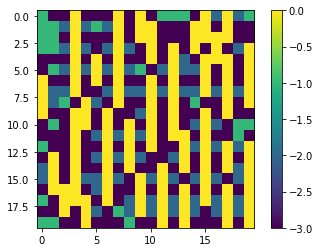

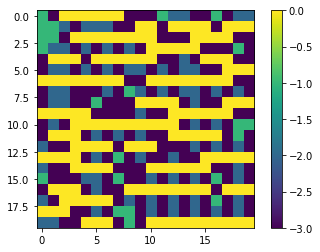

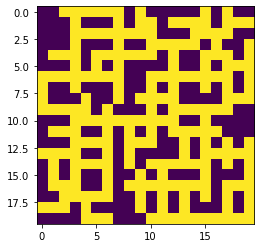

['agar', 'ahn', 'arie', 'basilika', 'beneiden', 'boe', 'cherub', 'dank1', 'die', 'don', 'dugong', 'dur', 'egal', 'einklang', 'ergo', 'erraten', 'ethologie', 'frei', 'gehweg', 'gel', 'gin', 'gmbh', 'gon', 'hai', 'hellseher', 'heuer', 'huefte', 'ido', 'index', 'irgendwo', 'kuendigen', 'lama0', 'logo', 'lok', 'los0', 'lusaka', 'mai', 'makel', 'mehl', 'nadir', 'naiv', 'nautisch', 'nie', 'oase', 'ol', 'opa', 'osel', 'pkw', 'sekte', 'skalde', 'strich', 'taburett', 'terebinthe', 'und', 'uno', 'uran', 'usa', 'verknallen', 'verlierer', 'video', 'vor', 'weissbrot', 'zeh']


In [8]:
#for line in base_grid.letter_grid:
#    print("".join(line))

print(final_state.letter_grid)

plt.imshow(final_state.x_grid, vmax= 0)
plt.colorbar()
plt.show()
plt.imshow(final_state.y_grid, vmax= 0)
plt.colorbar()
plt.show()
plt.imshow(final_state.letter_grid != ' ')
plt.show()

print(sorted([word.word_key for word in final_state.placed_words]))

In [30]:
get_database("de")['ore']

{'word': 'Ore',
 'senses': ['Münze, die in Dänemark, Norwegen und Schweden verwendet wird'],
 'synonyms': [],
 'antonyms': [],
 'num_translations': 10}

In [21]:
def create_word_grid(w: int,
                     h: int,
                     lang_code: str = "en",
                     target_density: float = 0.8,
                     difficulty: int = 0):

    logging.info("generate new crossword with params: w:%s h:%s lang:%s density:%s difficulty:%s",
                 str(w),
                 str(h),
                 lang_code,
                 str(target_density),
                 str(difficulty))

    db = get_database(lang_code, difficulty=difficulty)
    inverted_db = get_inverted_database(lang_code, difficulty=difficulty)

    base_grid = GridCreationState(h=h, w=w, db=db, inverted_db=inverted_db)

    final_state = base_grid.fill_grid(target_density=target_density,
                                      inner_retries=5,
                                      conflict_solver_depth=20,
                                      min_length=3,
                                      max_iterations=max(size * 75, 1000))

    # generate word hints

    word_hints = {}

    opposite_prefix = "opposite of:" if lang_code == "en" else "Gegenteil von:"
    synonym_prefix = "other word for:" if lang_code == "en" else "anderes Wort für:"

    for placed_word in final_state.placed_words:
        word_key = placed_word.word_key
        word = normalize_word(db[word_key]['word'])
        y = placed_word.y
        x = placed_word.x
        is_vertical = placed_word.is_vertical

        word_info = WordInfo(word_key, y, x, is_vertical,
                             db, opposite_prefix, synonym_prefix)
        word_hints[word] = word_info

    # create a solution word

    char_locations = {}
    for char in list("abcdefghijklmnopqrstuvwxyz"):
        char_locations[char] = np.argwhere(
            final_state.letter_grid == char).tolist()

    words = list(db.keys())
    n_words = len(words)

    min_solution_length = 10
    max_solution_length = 20

    solution_word_locations = None

    while solution_word_locations is None:

        random_index = random.randint(0, n_words - 1)
        random_word_key = words[random_index]
        random_word = db[random_word_key]['word']
        normalized_random_word = normalize_word(random_word)
        if len(normalized_random_word) < min_solution_length or len(normalized_random_word) > max_solution_length:
            continue

        char_locations_copy = {}
        for char in char_locations:
            char_locations_copy[char] = char_locations[char].copy()
        
        solution = []
        
        aborted = False
        for char in list(normalized_random_word):
            if char not in char_locations_copy:
                aborted = True
                break
            locations = char_locations_copy[char]
            if len(locations) == 0:
                aborted = True
                break
            
            i = random.randint(0, len(locations) - 1)
            location = locations[i]
            del(locations[i])
            solution.append(location)
            
        
        if aborted:
            continue

        solution_word_locations = solution
                

    return final_state.letter_grid, word_hints, solution_word_locations


In [22]:
state, hints, solution = create_word_grid(10,10)

finished after 1500 iterations, with a density of 0.69


In [29]:
solution

[[6, 4],
 [6, 5],
 [6, 9],
 [3, 4],
 [5, 9],
 [4, 2],
 [8, 1],
 [8, 0],
 [1, 8],
 [8, 8]]

In [83]:
grid = final_state.letter_grid

In [95]:
[0,8] in np.argwhere(grid == "a").tolist()

False